In [64]:
import re
import numpy as np
import pandas as pd
from sklearn import tree
from sklearn import ensemble
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import optuna
from sklearn.metrics import log_loss

df = pd.read_csv('../data/train.csv')

# カテゴリデータを数値に変換
le = LabelEncoder()
df['Sex'] = le.fit_transform(df['Sex'])
df['Embarked'] = le.fit_transform(df['Embarked'])
df['FamilyName'] = df.apply(lambda row: row['Name'].split(' ')[0].replace(',', ''), axis=1)

# ファミリーネームごとの生存率
sr_by_family_name = df.groupby(by='FamilyName', as_index=False).mean()[['FamilyName', 'Survived']]
def getSRByFamilyName(row):
    family_name = row['FamilyName']
    sr = sr_by_family_name[sr_by_family_name['FamilyName'] == family_name]['Survived']
    if sr.size == 0:
        return 0
    else:
        return sr.iloc[0]
df['SRFamilyName'] = df.apply(getSRByFamilyName, axis=1)

# 乗車番号
tickets = df['Ticket'].str.split()
tickets = [ticket[-1] if len(ticket) > 1 else ticket[0] for ticket in tickets]
tickets = [int(elem) if elem.isdigit() else 9999999 for elem in tickets]
df['Ticket'] = tickets

# 敬称
def getTitle(row):
    name = row['Name']
    p = re.compile('.*\ (.*)\.\ .*')
    surname = p.search(name)
    return surname.group(1)
df['Title'] = df.apply(getTitle, axis=1)

# 敬称ごとの年齢の中央値を取得し、Age の欠損値を敬称ごとの中央値で補完
df_title_ages = df.groupby('Title').median()['Age']
def getAgeByTitle(title):
    return df_title_ages[title]
def fillNaByTitle(row):
    if pd.isna(row['Age']):
        return getAgeByTitle(row['Title'])
    else:
        return row['Age']
df['Age'] = df.apply(fillNaByTitle, axis=1)

df.isnull().sum()

PassengerId       0
Survived          0
Pclass            0
Name              0
Sex               0
Age               0
SibSp             0
Parch             0
Ticket            0
Fare              0
Cabin           687
Embarked          0
FamilyName        0
SRFamilyName      0
Title             0
dtype: int64

In [65]:
not_need_columns = [
    'PassengerId', 'Name', 'Cabin', 'FamilyName', 'Title'
]

train_df = df.drop(axis=1, columns=not_need_columns)
# test_df = Test_df.drop(axis=1, columns=not_need_columns)
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,SRFamilyName
0,0,3,1,22.0,1,0,21171,7.2500,2,0.0
1,1,1,0,38.0,1,0,17599,71.2833,0,1.0
2,1,3,0,26.0,0,0,3101282,7.9250,2,1.0
3,1,1,0,35.0,1,0,113803,53.1000,2,0.5
4,0,3,1,35.0,0,0,373450,8.0500,2,0.5


In [66]:
X_train = train_df.drop(axis=1, columns=['Survived'])
Y_train = train_df.loc[:, ['Survived']]

x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, random_state=1)

Text(0.5, 0.98, 'Accuracy per each depth')

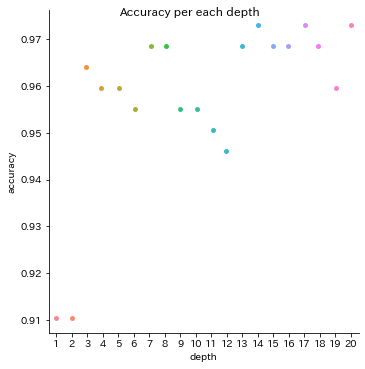

In [67]:
# Decision Tree
accuracies = []
r2_scores = []
dec_max_acc_depth = 0
dec_max_acc = 0
for i in range(20):
    clf = tree.DecisionTreeClassifier(max_depth=i+1)
    model = clf.fit(x_train, y_train)
    predicted = model.predict(x_test)
    dec_acc = accuracy_score(y_test, predicted)
    accuracies.append((i + 1, dec_acc)) 
    R2 = r2_score(y_test, predicted)
    r2_scores.append((i + 1, R2))
    if dec_max_acc < dec_acc:
        dec_max_acc_depth = i + 1
        dec_max_acc = dec_acc
    
df_ac = pd.DataFrame(accuracies, columns=['depth', 'accuracy'])
g = sns.catplot(x='depth', y='accuracy', data=df_ac)
g.fig.suptitle('Accuracy per each depth')

In [68]:
print('Depth: {}, Accuracy: {}'.format(dec_max_acc_depth, dec_max_acc))

Depth: 14, Accuracy: 0.9730941704035875


Text(0.5, 0.98, 'Accuracy per each depth')

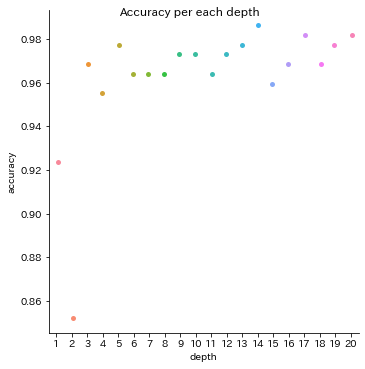

In [69]:
# Random Forest
rf_accuracies = []
rf_r2_scores = []
for i in range(20):
    rf_clf = ensemble.RandomForestClassifier(n_estimators=i+1)
    rf_model = rf_clf.fit(x_train, y_train.values.ravel())
    rf_predicted = rf_model.predict(x_test)
    rf_accuracies.append((i + 1, accuracy_score(y_test, rf_predicted))) 
    rf_R2 = r2_score(y_test, rf_predicted)
    rf_r2_scores.append((i + 1, rf_R2))

rf_max_acc_depth = 0
rf_max_acc = 0
for each_acc in rf_accuracies:
    depth, acc = each_acc
    if acc > rf_max_acc:
        rf_max_acc_depth = depth
        rf_max_acc = acc

df_rf_ac = pd.DataFrame(rf_accuracies, columns=['depth', 'accuracy'])
g = sns.catplot(x='depth', y='accuracy', data=df_rf_ac)
g.fig.suptitle('Accuracy per each depth')

In [70]:
print('Depth: {}, Accuracy: {}'.format(rf_max_acc_depth, rf_max_acc))

Depth: 14, Accuracy: 0.9865470852017937


<AxesSubplot:xlabel='importances', ylabel='features'>

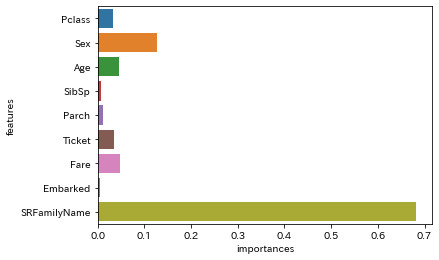

In [71]:
# 特徴量を算出
rf_clf_max = ensemble.RandomForestClassifier(n_estimators=rf_max_acc_depth)
rf_model_max = rf_clf.fit(x_train, y_train.values.ravel())
feature_importances = pd.DataFrame([x_train.columns, rf_model_max.feature_importances_]).T
feature_importances.columns = ['features', 'importances']
sns.barplot(
    x=feature_importances['importances'],
    y=feature_importances['features'],
    data=feature_importances
)

In [75]:
# LightGBM
def objective(trial):
    params = {
        'objective': 'binary',
        'max_depth': trial.suggest_int('max_depth', 1, 20),
        'verbose': -1,
        'max_bin': trial.suggest_int('max_bin', 255, 500),
        'learning_rate': 0.05,
        'num_leaves': trial.suggest_int('num_leaves', 32, 128),
    }

    categorical_features=['Pclass', 'Sex', 'Parch', 'Embarked']
    lgb_train = lgb.Dataset(x_train, y_train, categorical_feature=categorical_features)
    lgb_eval = lgb.Dataset(x_test, y_test, reference=lgb_train, categorical_feature=categorical_features)
    model = lgb.train(params, lgb_train,
                      valid_sets=[lgb_train, lgb_eval],
                      verbose_eval=10,
                      num_boost_round=1000,
                      early_stopping_rounds=10)

    y_pred_valid = model.predict(x_test, num_iteration=model.best_iteration)
    score = log_loss(y_test, y_pred_valid)
    return score

study = optuna.create_study(sampler=optuna.samplers.RandomSampler(seed=0))
study.optimize(objective, n_trials=40)

[I 2021-04-20 23:54:15,488] A new study created in memory with name: no-name-c1d89263-2af6-4c3b-9712-b97aa670518d
/Users/m000732/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/m000732/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/m000732/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))
[I 2021-04-20 23:54:15,667] Trial 0 finished with value: 0.07919183912229523 and parameters: {'max_depth': 11, 'max_bin': 430, 'num_leaves': 90}. Best is trial 0 with value: 0.07919183912229523.
/Users/m000732/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:155

Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.367528	valid_1's binary_logloss: 0.38336
[20]	training's binary_logloss: 0.233571	valid_1's binary_logloss: 0.245527
[30]	training's binary_logloss: 0.161849	valid_1's binary_logloss: 0.176704
[40]	training's binary_logloss: 0.118796	valid_1's binary_logloss: 0.139113
[50]	training's binary_logloss: 0.0928534	valid_1's binary_logloss: 0.117961
[60]	training's binary_logloss: 0.0764908	valid_1's binary_logloss: 0.103686
[70]	training's binary_logloss: 0.0657937	valid_1's binary_logloss: 0.0955145
[80]	training's binary_logloss: 0.0578241	valid_1's binary_logloss: 0.091545
[90]	training's binary_logloss: 0.0516187	valid_1's binary_logloss: 0.0901936
[100]	training's binary_logloss: 0.041318	valid_1's binary_logloss: 0.0831349
[110]	training's binary_logloss: 0.0327559	valid_1's binary_logloss: 0.0800519
[120]	training's binary_logloss: 0.0269244	valid_1's binary_logloss: 0.0800969
Early stoppin

[I 2021-04-20 23:54:15,847] Trial 1 finished with value: 0.07919183912229523 and parameters: {'max_depth': 11, 'max_bin': 359, 'num_leaves': 94}. Best is trial 0 with value: 0.07919183912229523.
/Users/m000732/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/m000732/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/m000732/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))
[I 2021-04-20 23:54:15,928] Trial 2 finished with value: 0.07471854461850691 and parameters: {'max_depth': 9, 'max_bin': 474, 'num_leaves': 125}. Best is trial 2 with value: 0.0747185446185069

[50]	training's binary_logloss: 0.0928534	valid_1's binary_logloss: 0.117961
[60]	training's binary_logloss: 0.0764908	valid_1's binary_logloss: 0.103686
[70]	training's binary_logloss: 0.0657937	valid_1's binary_logloss: 0.0955145
[80]	training's binary_logloss: 0.0578241	valid_1's binary_logloss: 0.091545
[90]	training's binary_logloss: 0.0516187	valid_1's binary_logloss: 0.0901936
[100]	training's binary_logloss: 0.041318	valid_1's binary_logloss: 0.0831349
[110]	training's binary_logloss: 0.0327559	valid_1's binary_logloss: 0.0800519
[120]	training's binary_logloss: 0.0269244	valid_1's binary_logloss: 0.0800969
Early stopping, best iteration is:
[115]	training's binary_logloss: 0.0291496	valid_1's binary_logloss: 0.0791918
Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.367528	valid_1's binary_logloss: 0.38336
[20]	training's binary_logloss: 0.233571	valid_1's binary_logloss: 0.245527
[30]	training's binary_logloss: 0.161849	valid_1's 

/Users/m000732/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/m000732/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/m000732/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))
[I 2021-04-20 23:54:16,032] Trial 3 finished with value: 0.07729411912994165 and parameters: {'max_depth': 8, 'max_bin': 449, 'num_leaves': 83}. Best is trial 2 with value: 0.07471854461850691.
/Users/m000732/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Use

Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.367528	valid_1's binary_logloss: 0.38336
[20]	training's binary_logloss: 0.233571	valid_1's binary_logloss: 0.245527
[30]	training's binary_logloss: 0.161849	valid_1's binary_logloss: 0.176704
[40]	training's binary_logloss: 0.118796	valid_1's binary_logloss: 0.139113
[50]	training's binary_logloss: 0.0928534	valid_1's binary_logloss: 0.117961
[60]	training's binary_logloss: 0.0764908	valid_1's binary_logloss: 0.103686
[70]	training's binary_logloss: 0.0657937	valid_1's binary_logloss: 0.0955145
[80]	training's binary_logloss: 0.0578241	valid_1's binary_logloss: 0.091545
[90]	training's binary_logloss: 0.0516187	valid_1's binary_logloss: 0.0901936
[100]	training's binary_logloss: 0.0428147	valid_1's binary_logloss: 0.0859276
[110]	training's binary_logloss: 0.0357177	valid_1's binary_logloss: 0.0823984
[120]	training's binary_logloss: 0.0301568	valid_1's binary_logloss: 0.0808408
[130]	traini

[I 2021-04-20 23:54:16,161] Trial 5 finished with value: 0.1016021048559643 and parameters: {'max_depth': 2, 'max_bin': 259, 'num_leaves': 112}. Best is trial 2 with value: 0.07471854461850691.
/Users/m000732/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/m000732/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/m000732/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))
[I 2021-04-20 23:54:16,229] Trial 6 finished with value: 0.07868810936834533 and parameters: {'max_depth': 16, 'max_bin': 469, 'num_leaves': 126}. Best is trial 2 with value: 0.0747185446185069

[110]	training's binary_logloss: 0.0772959	valid_1's binary_logloss: 0.101602
[120]	training's binary_logloss: 0.0746052	valid_1's binary_logloss: 0.101877
Early stopping, best iteration is:
[110]	training's binary_logloss: 0.0772959	valid_1's binary_logloss: 0.101602
Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.367528	valid_1's binary_logloss: 0.38336
[20]	training's binary_logloss: 0.233571	valid_1's binary_logloss: 0.245527
[30]	training's binary_logloss: 0.161849	valid_1's binary_logloss: 0.176704
[40]	training's binary_logloss: 0.118796	valid_1's binary_logloss: 0.139113
[50]	training's binary_logloss: 0.0928534	valid_1's binary_logloss: 0.117961
[60]	training's binary_logloss: 0.0764908	valid_1's binary_logloss: 0.103686
[70]	training's binary_logloss: 0.0657937	valid_1's binary_logloss: 0.0955145
[80]	training's binary_logloss: 0.0578241	valid_1's binary_logloss: 0.091545
[90]	training's binary_logloss: 0.0516187	valid_1's binary

[I 2021-04-20 23:54:16,385] Trial 8 finished with value: 0.07434087206084815 and parameters: {'max_depth': 3, 'max_bin': 412, 'num_leaves': 45}. Best is trial 8 with value: 0.07434087206084815.
/Users/m000732/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/m000732/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/m000732/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))
[I 2021-04-20 23:54:16,488] Trial 9 finished with value: 0.07868810931973019 and parameters: {'max_depth': 19, 'max_bin': 383, 'num_leaves': 72}. Best is trial 8 with value: 0.07434087206084815

[110]	training's binary_logloss: 0.0585728	valid_1's binary_logloss: 0.0896602
[120]	training's binary_logloss: 0.0549744	valid_1's binary_logloss: 0.0887193
[130]	training's binary_logloss: 0.0518576	valid_1's binary_logloss: 0.0860505
[140]	training's binary_logloss: 0.048703	valid_1's binary_logloss: 0.0858947
[150]	training's binary_logloss: 0.0449749	valid_1's binary_logloss: 0.0828322
[160]	training's binary_logloss: 0.0420072	valid_1's binary_logloss: 0.080671
[170]	training's binary_logloss: 0.0394088	valid_1's binary_logloss: 0.0784364
[180]	training's binary_logloss: 0.03596	valid_1's binary_logloss: 0.0762126
[190]	training's binary_logloss: 0.0332685	valid_1's binary_logloss: 0.0750091
[200]	training's binary_logloss: 0.0302788	valid_1's binary_logloss: 0.0745073
Early stopping, best iteration is:
[199]	training's binary_logloss: 0.030409	valid_1's binary_logloss: 0.0743409
Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.367528

[I 2021-04-20 23:54:16,912] Trial 10 finished with value: 0.07067726323220652 and parameters: {'max_depth': 6, 'max_bin': 445, 'num_leaves': 76}. Best is trial 10 with value: 0.07067726323220652.


[20]	training's binary_logloss: 0.233571	valid_1's binary_logloss: 0.245528
[30]	training's binary_logloss: 0.161849	valid_1's binary_logloss: 0.176705
[40]	training's binary_logloss: 0.118797	valid_1's binary_logloss: 0.139113
[50]	training's binary_logloss: 0.0928536	valid_1's binary_logloss: 0.117961
[60]	training's binary_logloss: 0.0764909	valid_1's binary_logloss: 0.103686
[70]	training's binary_logloss: 0.0657939	valid_1's binary_logloss: 0.095514
[80]	training's binary_logloss: 0.0577254	valid_1's binary_logloss: 0.0916632
[90]	training's binary_logloss: 0.0519217	valid_1's binary_logloss: 0.0898977
[100]	training's binary_logloss: 0.0444681	valid_1's binary_logloss: 0.0874522
[110]	training's binary_logloss: 0.0382166	valid_1's binary_logloss: 0.08611
[120]	training's binary_logloss: 0.0337978	valid_1's binary_logloss: 0.0838983
[130]	training's binary_logloss: 0.029855	valid_1's binary_logloss: 0.0816336
[140]	training's binary_logloss: 0.0261841	valid_1's binary_logloss: 0.0

/Users/m000732/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/m000732/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/m000732/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))
[I 2021-04-20 23:54:16,995] Trial 11 finished with value: 0.07830186268804654 and parameters: {'max_depth': 12, 'max_bin': 259, 'num_leaves': 91}. Best is trial 10 with value: 0.07067726323220652.
/Users/m000732/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/

[30]	training's binary_logloss: 0.161849	valid_1's binary_logloss: 0.176704
[40]	training's binary_logloss: 0.118796	valid_1's binary_logloss: 0.139113
[50]	training's binary_logloss: 0.0928534	valid_1's binary_logloss: 0.117961
[60]	training's binary_logloss: 0.0764908	valid_1's binary_logloss: 0.103686
[70]	training's binary_logloss: 0.0657937	valid_1's binary_logloss: 0.0955145
[80]	training's binary_logloss: 0.0578241	valid_1's binary_logloss: 0.091545
[90]	training's binary_logloss: 0.0516187	valid_1's binary_logloss: 0.0901936
[100]	training's binary_logloss: 0.0412662	valid_1's binary_logloss: 0.0830249
[110]	training's binary_logloss: 0.0321734	valid_1's binary_logloss: 0.0784654
Early stopping, best iteration is:
[109]	training's binary_logloss: 0.0324743	valid_1's binary_logloss: 0.0783019
Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.367528	valid_1's binary_logloss: 0.38336
[20]	training's binary_logloss: 0.233571	valid_1's bi

/Users/m000732/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/m000732/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/m000732/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))
[I 2021-04-20 23:54:17,238] Trial 14 finished with value: 0.07869385618118177 and parameters: {'max_depth': 14, 'max_bin': 269, 'num_leaves': 96}. Best is trial 10 with value: 0.07067726323220652.
/Users/m000732/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/

[10]	training's binary_logloss: 0.367528	valid_1's binary_logloss: 0.38336
[20]	training's binary_logloss: 0.233571	valid_1's binary_logloss: 0.245527
[30]	training's binary_logloss: 0.161849	valid_1's binary_logloss: 0.176704
[40]	training's binary_logloss: 0.118796	valid_1's binary_logloss: 0.139113
[50]	training's binary_logloss: 0.0928534	valid_1's binary_logloss: 0.117961
[60]	training's binary_logloss: 0.0764908	valid_1's binary_logloss: 0.103686
[70]	training's binary_logloss: 0.0657937	valid_1's binary_logloss: 0.0955145
[80]	training's binary_logloss: 0.0578241	valid_1's binary_logloss: 0.091545
[90]	training's binary_logloss: 0.0516187	valid_1's binary_logloss: 0.0901936
[100]	training's binary_logloss: 0.0412662	valid_1's binary_logloss: 0.0830249
[110]	training's binary_logloss: 0.0323457	valid_1's binary_logloss: 0.0799524
[120]	training's binary_logloss: 0.025644	valid_1's binary_logloss: 0.0787131
Early stopping, best iteration is:
[113]	training's binary_logloss: 0.0300

[I 2021-04-20 23:54:17,425] Trial 16 finished with value: 0.07238661768021758 and parameters: {'max_depth': 7, 'max_bin': 344, 'num_leaves': 87}. Best is trial 10 with value: 0.07067726323220652.
/Users/m000732/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/m000732/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/m000732/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))
[I 2021-04-20 23:54:17,522] Trial 17 finished with value: 0.07471854461850691 and parameters: {'max_depth': 9, 'max_bin': 498, 'num_leaves': 41}. Best is trial 10 with value: 0.07067726323220

[30]	training's binary_logloss: 0.161849	valid_1's binary_logloss: 0.176704
[40]	training's binary_logloss: 0.118796	valid_1's binary_logloss: 0.139113
[50]	training's binary_logloss: 0.0928534	valid_1's binary_logloss: 0.117961
[60]	training's binary_logloss: 0.0764908	valid_1's binary_logloss: 0.103686
[70]	training's binary_logloss: 0.0657937	valid_1's binary_logloss: 0.0955145
[80]	training's binary_logloss: 0.0578241	valid_1's binary_logloss: 0.091545
[90]	training's binary_logloss: 0.0516187	valid_1's binary_logloss: 0.0901936
[100]	training's binary_logloss: 0.0433713	valid_1's binary_logloss: 0.0846817
[110]	training's binary_logloss: 0.0365015	valid_1's binary_logloss: 0.0824156
[120]	training's binary_logloss: 0.0320033	valid_1's binary_logloss: 0.0823468
[130]	training's binary_logloss: 0.0270145	valid_1's binary_logloss: 0.0819247
[140]	training's binary_logloss: 0.0229994	valid_1's binary_logloss: 0.0793013
[150]	training's binary_logloss: 0.0198274	valid_1's binary_loglos

/Users/m000732/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))
[I 2021-04-20 23:54:17,662] Trial 18 finished with value: 0.07993363177676753 and parameters: {'max_depth': 5, 'max_bin': 294, 'num_leaves': 95}. Best is trial 10 with value: 0.07067726323220652.
/Users/m000732/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/m000732/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/m000732/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'

[30]	training's binary_logloss: 0.161849	valid_1's binary_logloss: 0.176703
[40]	training's binary_logloss: 0.119426	valid_1's binary_logloss: 0.140384
[50]	training's binary_logloss: 0.0944121	valid_1's binary_logloss: 0.120806
[60]	training's binary_logloss: 0.0786573	valid_1's binary_logloss: 0.108393
[70]	training's binary_logloss: 0.0685386	valid_1's binary_logloss: 0.101117
[80]	training's binary_logloss: 0.0607423	valid_1's binary_logloss: 0.0972323
[90]	training's binary_logloss: 0.0544082	valid_1's binary_logloss: 0.0940593
[100]	training's binary_logloss: 0.0488768	valid_1's binary_logloss: 0.0919994
[110]	training's binary_logloss: 0.0438092	valid_1's binary_logloss: 0.0889919
[120]	training's binary_logloss: 0.0388316	valid_1's binary_logloss: 0.0870192
[130]	training's binary_logloss: 0.0338987	valid_1's binary_logloss: 0.0862408
[140]	training's binary_logloss: 0.0301397	valid_1's binary_logloss: 0.084225
[150]	training's binary_logloss: 0.0267533	valid_1's binary_logloss

[I 2021-04-20 23:54:17,801] Trial 19 finished with value: 0.07067726323220652 and parameters: {'max_depth': 6, 'max_bin': 369, 'num_leaves': 55}. Best is trial 10 with value: 0.07067726323220652.
/Users/m000732/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/m000732/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/m000732/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))
[I 2021-04-20 23:54:17,894] Trial 20 finished with value: 0.08687667098919274 and parameters: {'max_depth': 4, 'max_bin': 282, 'num_leaves': 95}. Best is trial 10 with value: 0.07067726323220

[170]	training's binary_logloss: 0.0168266	valid_1's binary_logloss: 0.0723397
[180]	training's binary_logloss: 0.0146196	valid_1's binary_logloss: 0.0708865
[190]	training's binary_logloss: 0.0119523	valid_1's binary_logloss: 0.0724885
Early stopping, best iteration is:
[184]	training's binary_logloss: 0.0136901	valid_1's binary_logloss: 0.0706773
Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.367744	valid_1's binary_logloss: 0.383354
[20]	training's binary_logloss: 0.234355	valid_1's binary_logloss: 0.245912
[30]	training's binary_logloss: 0.162924	valid_1's binary_logloss: 0.177088
[40]	training's binary_logloss: 0.121471	valid_1's binary_logloss: 0.139546
[50]	training's binary_logloss: 0.0966308	valid_1's binary_logloss: 0.117791
[60]	training's binary_logloss: 0.0816735	valid_1's binary_logloss: 0.107054
[70]	training's binary_logloss: 0.0721011	valid_1's binary_logloss: 0.0993854
[80]	training's binary_logloss: 0.0645412	valid_1's 

/Users/m000732/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/m000732/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/m000732/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))
[I 2021-04-20 23:54:17,986] Trial 21 finished with value: 0.07434087206084815 and parameters: {'max_depth': 3, 'max_bin': 303, 'num_leaves': 67}. Best is trial 10 with value: 0.07067726323220652.
/Users/m000732/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/U

Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.367528	valid_1's binary_logloss: 0.38336
[20]	training's binary_logloss: 0.233571	valid_1's binary_logloss: 0.245527
[30]	training's binary_logloss: 0.161849	valid_1's binary_logloss: 0.176704
[40]	training's binary_logloss: 0.118796	valid_1's binary_logloss: 0.139113
[50]	training's binary_logloss: 0.0928534	valid_1's binary_logloss: 0.117961
[60]	training's binary_logloss: 0.0764908	valid_1's binary_logloss: 0.103686
[70]	training's binary_logloss: 0.0657937	valid_1's binary_logloss: 0.0955145
[80]	training's binary_logloss: 0.0578241	valid_1's binary_logloss: 0.091545
[90]	training's binary_logloss: 0.0516187	valid_1's binary_logloss: 0.0901936
[100]	training's binary_logloss: 0.0412662	valid_1's binary_logloss: 0.0830249
[110]	training's binary_logloss: 0.0323455	valid_1's binary_logloss: 0.0799466
[120]	training's binary_logloss: 0.0256438	valid_1's binary_logloss: 0.0787072
Early stoppi

[I 2021-04-20 23:54:18,210] Trial 24 finished with value: 0.07868810931973019 and parameters: {'max_depth': 20, 'max_bin': 403, 'num_leaves': 103}. Best is trial 10 with value: 0.07067726323220652.
/Users/m000732/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/m000732/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/m000732/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))
[I 2021-04-20 23:54:18,258] Trial 25 finished with value: 0.10190907256146231 and parameters: {'max_depth': 1, 'max_bin': 324, 'num_leaves': 43}. Best is trial 10 with value: 0.070677263232

Early stopping, best iteration is:
[113]	training's binary_logloss: 0.0300532	valid_1's binary_logloss: 0.0786881
Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.41586	valid_1's binary_logloss: 0.438056
[20]	training's binary_logloss: 0.301147	valid_1's binary_logloss: 0.318695
[30]	training's binary_logloss: 0.23684	valid_1's binary_logloss: 0.250351
[40]	training's binary_logloss: 0.196876	valid_1's binary_logloss: 0.208548
[50]	training's binary_logloss: 0.16942	valid_1's binary_logloss: 0.179751
[60]	training's binary_logloss: 0.149839	valid_1's binary_logloss: 0.159384
[70]	training's binary_logloss: 0.135427	valid_1's binary_logloss: 0.144382
[80]	training's binary_logloss: 0.124525	valid_1's binary_logloss: 0.133105
[90]	training's binary_logloss: 0.11612	valid_1's binary_logloss: 0.124408
[100]	training's binary_logloss: 0.10949	valid_1's binary_logloss: 0.11832
[110]	training's binary_logloss: 0.104012	valid_1's binary_logloss: 0.

/Users/m000732/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/m000732/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/m000732/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))
[I 2021-04-20 23:54:18,427] Trial 27 finished with value: 0.07471854461850691 and parameters: {'max_depth': 9, 'max_bin': 270, 'num_leaves': 99}. Best is trial 10 with value: 0.07067726323220652.
/Users/m000732/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/U

[130]	training's binary_logloss: 0.0226213	valid_1's binary_logloss: 0.0760479
Early stopping, best iteration is:
[122]	training's binary_logloss: 0.026753	valid_1's binary_logloss: 0.0747185
Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.367528	valid_1's binary_logloss: 0.38336
[20]	training's binary_logloss: 0.233571	valid_1's binary_logloss: 0.245527
[30]	training's binary_logloss: 0.161849	valid_1's binary_logloss: 0.176704
[40]	training's binary_logloss: 0.118796	valid_1's binary_logloss: 0.139113
[50]	training's binary_logloss: 0.0928534	valid_1's binary_logloss: 0.117961
[60]	training's binary_logloss: 0.0764908	valid_1's binary_logloss: 0.103686
[70]	training's binary_logloss: 0.0657937	valid_1's binary_logloss: 0.0955145
[80]	training's binary_logloss: 0.0578241	valid_1's binary_logloss: 0.091545
[90]	training's binary_logloss: 0.0516187	valid_1's binary_logloss: 0.0901936
[100]	training's binary_logloss: 0.0412662	valid_1's bina

/Users/m000732/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/m000732/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/m000732/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))
[I 2021-04-20 23:54:18,771] Trial 30 finished with value: 0.07238661768021758 and parameters: {'max_depth': 7, 'max_bin': 419, 'num_leaves': 44}. Best is trial 10 with value: 0.07067726323220652.
/Users/m000732/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[70]	training's binary_logloss: 0.0657937	valid_1's binary_logloss: 0.0955145
[80]	training's binary_logloss: 0.0578241	valid_1's binary_logloss: 0.091545
[90]	training's binary_logloss: 0.0516187	valid_1's binary_logloss: 0.0901936
[100]	training's binary_logloss: 0.0433713	valid_1's binary_logloss: 0.0846817
[110]	training's binary_logloss: 0.0365015	valid_1's binary_logloss: 0.0824156
[120]	training's binary_logloss: 0.0320033	valid_1's binary_logloss: 0.0823468
[130]	training's binary_logloss: 0.0270145	valid_1's binary_logloss: 0.0819247
[140]	training's binary_logloss: 0.0229994	valid_1's binary_logloss: 0.0793013
[150]	training's binary_logloss: 0.0198274	valid_1's binary_logloss: 0.0771631
[160]	training's binary_logloss: 0.0168454	valid_1's binary_logloss: 0.0735129
[170]	training's binary_logloss: 0.0140515	valid_1's binary_logloss: 0.0733416
[180]	training's binary_logloss: 0.0117501	valid_1's binary_logloss: 0.073367
Early stopping, best iteration is:
[177]	training's binar

/Users/m000732/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/m000732/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))
[I 2021-04-20 23:54:18,860] Trial 31 finished with value: 0.07868396076628803 and parameters: {'max_depth': 15, 'max_bin': 326, 'num_leaves': 49}. Best is trial 10 with value: 0.07067726323220652.
/Users/m000732/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/m000732/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters fro

[100]	training's binary_logloss: 0.0412662	valid_1's binary_logloss: 0.0830249
[110]	training's binary_logloss: 0.0323455	valid_1's binary_logloss: 0.0799425
[120]	training's binary_logloss: 0.0256439	valid_1's binary_logloss: 0.0787031
Early stopping, best iteration is:
[113]	training's binary_logloss: 0.0300532	valid_1's binary_logloss: 0.078684
Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.367528	valid_1's binary_logloss: 0.38336
[20]	training's binary_logloss: 0.233571	valid_1's binary_logloss: 0.245527
[30]	training's binary_logloss: 0.161849	valid_1's binary_logloss: 0.176704
[40]	training's binary_logloss: 0.118796	valid_1's binary_logloss: 0.139113
[50]	training's binary_logloss: 0.0928534	valid_1's binary_logloss: 0.117961
[60]	training's binary_logloss: 0.0764908	valid_1's binary_logloss: 0.103686
[70]	training's binary_logloss: 0.0657937	valid_1's binary_logloss: 0.0955145
[80]	training's binary_logloss: 0.0578241	valid_1's bi

/Users/m000732/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/m000732/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/m000732/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))
[I 2021-04-20 23:54:19,113] Trial 34 finished with value: 0.07868396076628803 and parameters: {'max_depth': 15, 'max_bin': 491, 'num_leaves': 56}. Best is trial 10 with value: 0.07067726323220652.
/Users/m000732/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/

[40]	training's binary_logloss: 0.118796	valid_1's binary_logloss: 0.139113
[50]	training's binary_logloss: 0.0928534	valid_1's binary_logloss: 0.117961
[60]	training's binary_logloss: 0.0764908	valid_1's binary_logloss: 0.103686
[70]	training's binary_logloss: 0.0657937	valid_1's binary_logloss: 0.0955145
[80]	training's binary_logloss: 0.0578241	valid_1's binary_logloss: 0.091545
[90]	training's binary_logloss: 0.0516187	valid_1's binary_logloss: 0.0901936
[100]	training's binary_logloss: 0.0412662	valid_1's binary_logloss: 0.0830249
[110]	training's binary_logloss: 0.0323455	valid_1's binary_logloss: 0.0799425
[120]	training's binary_logloss: 0.0256439	valid_1's binary_logloss: 0.0787031
Early stopping, best iteration is:
[113]	training's binary_logloss: 0.0300532	valid_1's binary_logloss: 0.078684
Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.367528	valid_1's binary_logloss: 0.38336
[20]	training's binary_logloss: 0.233571	valid_1's 

/Users/m000732/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/m000732/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/m000732/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))
[I 2021-04-20 23:54:19,356] Trial 36 finished with value: 0.07993363177676753 and parameters: {'max_depth': 5, 'max_bin': 489, 'num_leaves': 75}. Best is trial 10 with value: 0.07067726323220652.
/Users/m000732/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/U

[30]	training's binary_logloss: 0.161849	valid_1's binary_logloss: 0.176703
[40]	training's binary_logloss: 0.119426	valid_1's binary_logloss: 0.140384
[50]	training's binary_logloss: 0.0944121	valid_1's binary_logloss: 0.120806
[60]	training's binary_logloss: 0.0786573	valid_1's binary_logloss: 0.108393
[70]	training's binary_logloss: 0.0685386	valid_1's binary_logloss: 0.101117
[80]	training's binary_logloss: 0.0607423	valid_1's binary_logloss: 0.0972323
[90]	training's binary_logloss: 0.0544082	valid_1's binary_logloss: 0.0940593
[100]	training's binary_logloss: 0.0488768	valid_1's binary_logloss: 0.0919994
[110]	training's binary_logloss: 0.0438092	valid_1's binary_logloss: 0.0889919
[120]	training's binary_logloss: 0.0388316	valid_1's binary_logloss: 0.0870192
[130]	training's binary_logloss: 0.0338987	valid_1's binary_logloss: 0.0862408
[140]	training's binary_logloss: 0.0301397	valid_1's binary_logloss: 0.084225
[150]	training's binary_logloss: 0.0267533	valid_1's binary_logloss

[I 2021-04-20 23:54:19,453] Trial 37 finished with value: 0.07868810931973019 and parameters: {'max_depth': 17, 'max_bin': 427, 'num_leaves': 60}. Best is trial 10 with value: 0.07067726323220652.
/Users/m000732/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/m000732/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/m000732/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))
[I 2021-04-20 23:54:19,548] Trial 38 finished with value: 0.07868810931973019 and parameters: {'max_depth': 17, 'max_bin': 352, 'num_leaves': 117}. Best is trial 10 with value: 0.07067726323


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.367528	valid_1's binary_logloss: 0.38336
[20]	training's binary_logloss: 0.233571	valid_1's binary_logloss: 0.245527
[30]	training's binary_logloss: 0.161849	valid_1's binary_logloss: 0.176704
[40]	training's binary_logloss: 0.118796	valid_1's binary_logloss: 0.139113
[50]	training's binary_logloss: 0.0928534	valid_1's binary_logloss: 0.117961
[60]	training's binary_logloss: 0.0764908	valid_1's binary_logloss: 0.103686
[70]	training's binary_logloss: 0.0657937	valid_1's binary_logloss: 0.0955145
[80]	training's binary_logloss: 0.0578241	valid_1's binary_logloss: 0.091545
[90]	training's binary_logloss: 0.0516187	valid_1's binary_logloss: 0.0901936
[100]	training's binary_logloss: 0.0412662	valid_1's binary_logloss: 0.0830249
[110]	training's binary_logloss: 0.0323455	valid_1's binary_logloss: 0.0799466
[120]	training's binary_logloss: 0.0256438	valid_1's binary_logloss: 0.0787072
Early stopp

[I 2021-04-20 23:54:19,661] Trial 39 finished with value: 0.07830186268804654 and parameters: {'max_depth': 12, 'max_bin': 471, 'num_leaves': 99}. Best is trial 10 with value: 0.07067726323220652.


Early stopping, best iteration is:
[109]	training's binary_logloss: 0.0324743	valid_1's binary_logloss: 0.0783019


{'max_depth': 6, 'max_bin': 445, 'num_leaves': 76}

In [76]:
study.best_params

{'max_depth': 6, 'max_bin': 445, 'num_leaves': 76}

In [78]:
params = {
    'objective': 'binary',
    'max_depth': 6,
    'verbose': -1,
    'max_bin': 445,
    'learning_rate': 0.05,
    'num_leaves': 76,
}

categorical_features=['Pclass', 'Sex', 'Parch', 'Embarked']
lgb_train = lgb.Dataset(x_train, y_train, categorical_feature=categorical_features)
lgb_eval = lgb.Dataset(x_test, y_test, reference=lgb_train, categorical_feature=categorical_features)
model = lgb.train(params, lgb_train,
                  valid_sets=[lgb_train, lgb_eval],
                  verbose_eval=10,
                  num_boost_round=1000,
                  early_stopping_rounds=10)

y_pred_valid = model.predict(x_test, num_iteration=model.best_iteration)
y_pred_valid = (y_pred_valid > 0.5).astype(int)
accuracy_score(y_test, y_pred_valid)

Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.367528	valid_1's binary_logloss: 0.383361
[20]	training's binary_logloss: 0.233571	valid_1's binary_logloss: 0.245528
[30]	training's binary_logloss: 0.161849	valid_1's binary_logloss: 0.176705
[40]	training's binary_logloss: 0.118797	valid_1's binary_logloss: 0.139113
[50]	training's binary_logloss: 0.0928536	valid_1's binary_logloss: 0.117961
[60]	training's binary_logloss: 0.0764909	valid_1's binary_logloss: 0.103686
[70]	training's binary_logloss: 0.0657939	valid_1's binary_logloss: 0.095514
[80]	training's binary_logloss: 0.0577254	valid_1's binary_logloss: 0.0916632
[90]	training's binary_logloss: 0.0519217	valid_1's binary_logloss: 0.0898977
[100]	training's binary_logloss: 0.0444681	valid_1's binary_logloss: 0.0874522
[110]	training's binary_logloss: 0.0382166	valid_1's binary_logloss: 0.08611
[120]	training's binary_logloss: 0.0337978	valid_1's binary_logloss: 0.0838983
[130]	trainin

/Users/m000732/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/m000732/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/m000732/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.9820627802690582